In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
#
# load data
#
df = pd.read_csv('synth_temp.csv')

In [3]:
#
# slice 1902 and forward
#
print(df.head())
df = df.loc[df.Year > 1901]
print(df.head())

  Region  Year  RgnAvTemp
0      A  1841  12.557395
1      B  1841  13.267048
2      E  1841  12.217463
3      F  1841  13.189420
4      A  1842  13.462887
    Region  Year  RgnAvTemp
292      A  1902  17.021583
293      B  1902  17.590253
294      C  1902  17.493082
295      D  1902  18.706166
296      E  1902  17.390903


In [4]:
#
# roll up by year
#
df_group_year = df.groupby(['Year', 'Region']).agg({'RgnAvTemp':'mean'})
#
# note that the .droplevel() method removes the multiindex 
# added by the .agg() method() to make things simpler
# later on in our analysis
#
print(df_group_year.head(12))
print(df_group_year.tail(12))

             RgnAvTemp
Year Region           
1902 A       17.021583
     B       17.590253
     C       17.493082
     D       18.706166
     E       17.390903
     F       17.438122
     G       18.494440
     H       15.708989
     I       19.012183
     J       17.292191
     K       15.020913
     L       17.451698
             RgnAvTemp
Year Region           
2010 A       19.732301
     B       20.161722
     C       19.922963
     D       21.221710
     E       19.571958
     F       19.903760
     G       21.511489
     H       16.867440
     I       23.772483
     J       18.982479
     K       17.462226
     L       19.918854


In [5]:
#
# add the region column so we can use that for dummy variables
#
df_group_year['Region'] = df_group_year.index.get_level_values(1)
#
# add the Year column so we can use that in a model
#
df_group_year['Year'] = df_group_year.index.get_level_values(0)
#
# reset the index on the long axis
#
df_group_year = df_group_year.droplevel(0, axis = 0)
df_group_year = df_group_year.reset_index(drop = True)

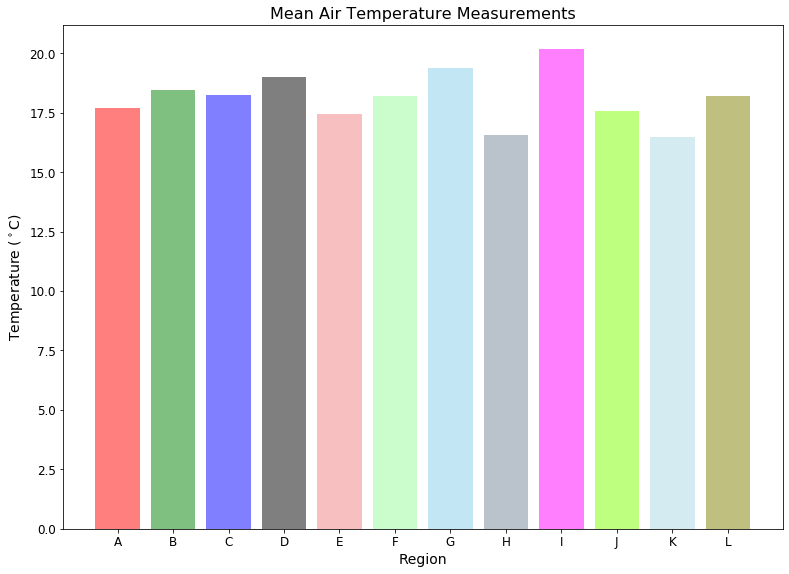

In [6]:
#
# inspect data by region
#
region_temps = df_group_year.groupby('Region').agg({'RgnAvTemp':'mean'})
colors = ['red', 'green', 'blue', 'black', 'lightcoral', 'palegreen',
          'skyblue', 'lightslategray', 'magenta', 'chartreuse', 'lightblue',
          'olive']
#
fig = plt.figure(figsize=(10, 7))
ax = fig.add_axes([1, 1, 1, 1])
ax.bar(region_temps.index, 
       region_temps.RgnAvTemp, 
       color = colors,
       alpha = 0.5)
#
ax.set_title('Mean Air Temperature Measurements',
             fontsize = 16)
#
ax.set_xlabel('Region', 
              fontsize = 14)
ax.set_ylabel('Temperature ($^\circ$C)', 
              fontsize = 14)
ax.tick_params(labelsize = 12)

In [7]:
#
# convert the categorical variable 'region' to dummy vars
#
dummy_cols = pd.get_dummies(df_group_year.Region, drop_first = True)
df_group_year = pd.concat([df_group_year, dummy_cols], axis = 1)
print(df_group_year.head())
print(df_group_year.tail())

   RgnAvTemp Region  Year  B  C  D  E  F  G  H  I  J  K  L
0  17.021583      A  1902  0  0  0  0  0  0  0  0  0  0  0
1  17.590253      B  1902  1  0  0  0  0  0  0  0  0  0  0
2  17.493082      C  1902  0  1  0  0  0  0  0  0  0  0  0
3  18.706166      D  1902  0  0  1  0  0  0  0  0  0  0  0
4  17.390903      E  1902  0  0  0  1  0  0  0  0  0  0  0
      RgnAvTemp Region  Year  B  C  D  E  F  G  H  I  J  K  L
1303  16.867440      H  2010  0  0  0  0  0  0  1  0  0  0  0
1304  23.772483      I  2010  0  0  0  0  0  0  0  1  0  0  0
1305  18.982479      J  2010  0  0  0  0  0  0  0  0  1  0  0
1306  17.462226      K  2010  0  0  0  0  0  0  0  0  0  1  0
1307  19.918854      L  2010  0  0  0  0  0  0  0  0  0  0  1


In [9]:
linear_model = LinearRegression(fit_intercept = True)
linear_model.fit(df_group_year.loc[:, 'Year':'L'],
                 df_group_year.RgnAvTemp)
r2 = linear_model.score(df_group_year.loc[:, 'Year':'L'],
                 df_group_year.RgnAvTemp)
print('r squared ', r2)

r squared  0.7778768442731825


In [10]:
#
# construct data to predict from model
#
pred_X = df_group_year.drop(['RgnAvTemp', 'Region'], axis = 1)
pred_Y = linear_model.predict(pred_X.values)
preds = pd.concat([df_group_year.RgnAvTemp, 
                   df_group_year.Region,
                   pred_X,  pd.Series(pred_Y)], axis = 1)
preds.rename(columns = {0 : 'pred_temp'}, inplace = True)
print(preds.head())

   RgnAvTemp Region  Year  B  C  D  E  F  G  H  I  J  K  L  pred_temp
0  17.021583      A  1902  0  0  0  0  0  0  0  0  0  0  0  16.441468
1  17.590253      B  1902  1  0  0  0  0  0  0  0  0  0  0  17.188189
2  17.493082      C  1902  0  1  0  0  0  0  0  0  0  0  0  16.977391
3  18.706166      D  1902  0  0  1  0  0  0  0  0  0  0  0  17.732365
4  17.390903      E  1902  0  0  0  1  0  0  0  0  0  0  0  16.195227


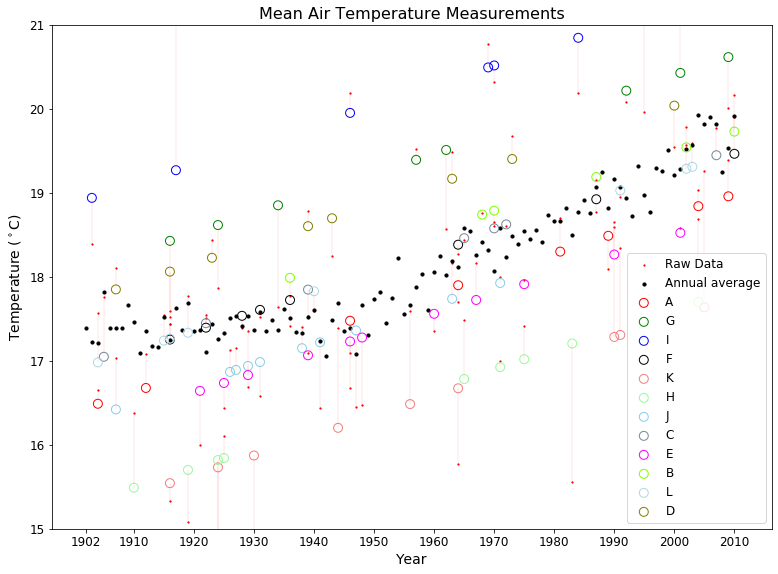

In [11]:
#
# define a sample of the raw data and predictions
#
plot_data = preds.sample(n = 100)
#
fig = plt.figure(figsize=(10, 7))
ax = fig.add_axes([1, 1, 1, 1])
#
# Raw data
#
raw_plot_data = plot_data
ax.scatter(raw_plot_data.Year, 
           raw_plot_data.RgnAvTemp, 
           label = 'Raw Data', 
           c = 'red', 
           s = 1.5)
#
# Annual averages
#
annual_plot_data = df_group_year.groupby('Year').agg('mean')
ax.scatter(annual_plot_data.index, 
           annual_plot_data.RgnAvTemp, 
           label = 'Annual average', 
           c = 'k',
           s = 10)
#
# linear fit results
#
fit_data = plot_data
for i in range(len(plot_data.Region.unique())):
    region = plot_data.Region.unique()[i]
    plot_region = fit_data.loc[fit_data.Region == region, :]
    ax.scatter(plot_region.Year,
               plot_region.pred_temp, 
               edgecolor = colors[i],
               facecolor = "none",
               s = 80,
               label = region)
#
# draw faint lines connecting the raw to the predicted
#
for i in fit_data.index:
    ax.plot([fit_data.Year[i], fit_data.Year[i]],
            [fit_data.pred_temp[i], fit_data.RgnAvTemp[i]],
            '-',
            linewidth = 0.1,
            c = "red")
#
ax.set_title('Mean Air Temperature Measurements',
             fontsize = 16)
#
# make the ticks include the first and last years
#
tick_years = [1902] + list(range(1910, 2011, 10))
ax.set_xlabel('Year', 
              fontsize = 14)
ax.set_ylabel('Temperature ($^\circ$C)', 
              fontsize = 14)
ax.set_ylim(15, 21)
ax.set_xticks(tick_years)
ax.tick_params(labelsize = 12)
ax.legend(fontsize = 12)

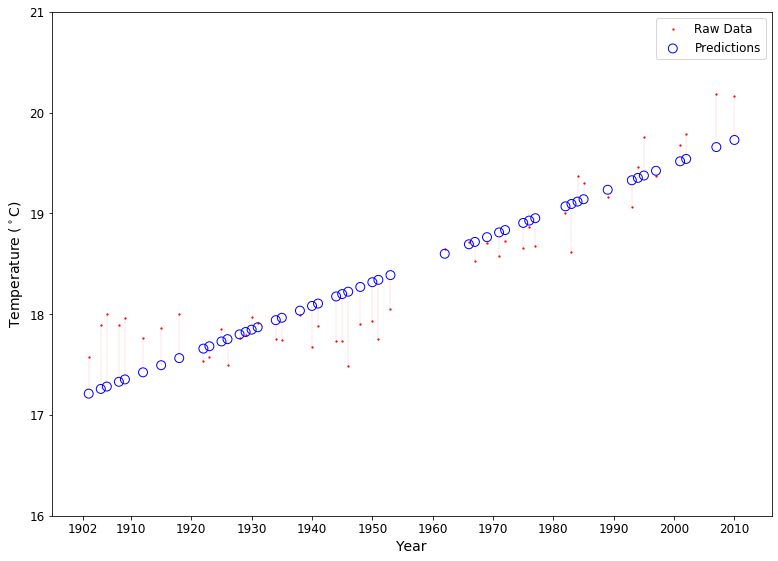

In [14]:
#
# let's plot just one region 
#
region_B = preds.loc[preds.B == 1, :]
plot_data = region_B.sample(n = 50)
#
fig = plt.figure(figsize=(10, 7))
ax = fig.add_axes([1, 1, 1, 1])
#
# Raw data
#
ax.scatter(plot_data.Year, 
           plot_data.RgnAvTemp, 
           label = 'Raw Data', 
           c = 'red', 
           s = 1.5)
ax.scatter(plot_data.Year,
           plot_data.pred_temp,
           label = "Predictions",
           facecolor = "none",
           edgecolor = "blue",
           s = 80)
#
# draw faint lines connecting the raw to the predicted
#
for i in plot_data.index:
    ax.plot([plot_data.Year[i], plot_data.Year[i]],
            [plot_data.pred_temp[i], plot_data.RgnAvTemp[i]],
            '-',
            linewidth = 0.1,
            c = "red")
#
# make the ticks include the first and last years
#
tick_years = [1902] + list(range(1910, 2011, 10))
ax.set_xlabel('Year', 
              fontsize = 14)
ax.set_ylabel('Temperature ($^\circ$C)', 
              fontsize = 14)
ax.set_ylim(16, 21)
ax.set_xticks(tick_years)
ax.tick_params(labelsize = 12)
ax.legend(fontsize = 12)